##Data Load and Pre-processing

# Libraries Install and Import

In [ ]:
import sys
!{sys.executable} -m pip install scikit-uplift catboost scikit-learn seaborn matplotlib pandas numpy
from sklift.datasets import fetch_lenta
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 875.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


# Dataset Load & feature conversion


In [ ]:
dataset = fetch_lenta()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")
dataset.keys()

treat_dict = {
    'test': 1,
    'control': 0
}
dataset.treatment = dataset.treatment.map(treat_dict)

gender_dict = {
    'M': 1,
    'Ж': 0
}
dataset.data.gender = dataset.data.gender.map(gender_dict)

Lenta dataset:   0%|          | 0.00/145M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


# Missing Values Imputation
# With mean values

In [ ]:
for h in dataset.data:
  col = dataset.data[h]
  m = np.mean(col)
  col = np.nan_to_num(col, nan=m)
  dataset.data[h] = col

print(dataset.data.isna().sum().sum())

0


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_UP_Train, X_UP_Test, T_UP_Train, T_UP_Test, Y_UP_Train, Y_UP_Test = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_UP_Train.shape}")
print(f"Test shape: {X_UP_Test.shape}")

Train shape: (480920, 193)
Test shape: (206109, 193)


# AUUQ graph function

In [ ]:
from sklift.metrics import uplift_auc_score
from sklift.viz import plot_uplift_curve

def display_auuq(name, mod, y_test, uplift_predicted, trmnt_test):
  uplift_disp = plot_uplift_curve(
    y_test, uplift_predicted, trmnt_test,
    perfect=False, name=name);
  uplift_disp.figure_.suptitle("Uplift curve of "+name);

# Uplift Evaluation Metrics

In [ ]:
from sklift.metrics import (uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklift.viz import plot_qini_curve

# ==== Model Score ====
def uplift_score(typed, name, slearner):
  slearner.fit(X=X_UP_Train, y=Y_UP_Train, model__treatment=T_UP_Train)
  uplift_slearner = slearner.predict(X_UP_Test)
  display_auuq(typed+"_"+name, slearner, Y_UP_Test, uplift_slearner, T_UP_Test)
  return [
      typed,
      name,
      uplift_at_k(y_true=Y_UP_Test, uplift=uplift_slearner,
                            treatment=T_UP_Test,
                            strategy='overall', k=0.1),
      qini_auc_score(y_true=Y_UP_Test, uplift=uplift_slearner,
                            treatment=T_UP_Test),
      uplift_auc_score(y_true=Y_UP_Test, uplift=uplift_slearner,
                                treatment=T_UP_Test),
      weighted_average_uplift(y_true=Y_UP_Test, uplift=uplift_slearner,
                            treatment=T_UP_Test)
      ]

# ==== Table Display ====
from IPython.display import display

def display_uplift(models): # [type, name, model]
  values = []
  for mod in models:
    print(mod[0], mod[1])
    acc = uplift_score(mod[0], mod[1], mod[2])
    values.append(acc)

  df = pd.DataFrame(values, columns=['type', 'model', 'uplift at 0.1', 'qini', 'auuc', 'wau'])
  display(df)

In [ ]:
# Response Models Definition
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


# Uplift Models Definition
from sklift.models import SoloModel, ClassTransformation, TwoModels

DT = DecisionTreeClassifier(max_depth=5, random_state=42)
ADA = AdaBoostClassifier(algorithm="SAMME", random_state=42)
GRAD = GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
CAT = CatBoostClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

UpliftModels = [
    ["Solo", "GradientBoost", SoloModel(GRAD)],
    ["Solo", "CatBoost", SoloModel(CAT)],

    ["Two", "Tree + Ada", TwoModels(estimator_trmnt=DT,estimator_ctrl=ADA,method='ddr_control')],
    ["Two", "Cat + Grad", TwoModels(estimator_trmnt=CAT,estimator_ctrl=GRAD,method='ddr_control')],
    ["Two", "Grad + Tree", TwoModels(estimator_trmnt=GRAD,estimator_ctrl=DT,method='ddr_control')],

    ["Class", "DescionTree", ClassTransformation(DT)],
    ["Class", "AdaBoost", ClassTransformation(ADA)],
    ["Class", "GradientBoost", ClassTransformation(GRAD)],
    ["Class", "CatBoost", ClassTransformation(CAT)]
]

In [ ]:
# Model Pipeline Pack
def pack_model(mod):
  imputer_model = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  return Pipeline([
      ('imputer', imputer_model),
      ('model', mod)
  ])

def pack_models(mods):
  a = []
  for mod in mods:
    a.append([mod[0], mod[1], pack_model(mod[2])])
  return a

# Table with results + AUUC visualisation

Solo GradientBoost
Solo CatBoost
0:	learn: 0.3100980	total: 151ms	remaining: 15s
1:	learn: 0.3043577	total: 300ms	remaining: 14.7s
2:	learn: 0.3022392	total: 455ms	remaining: 14.7s
3:	learn: 0.2970018	total: 604ms	remaining: 14.5s
4:	learn: 0.2951715	total: 755ms	remaining: 14.3s
5:	learn: 0.2936079	total: 907ms	remaining: 14.2s
6:	learn: 0.2925332	total: 1.07s	remaining: 14.3s
7:	learn: 0.2917678	total: 1.22s	remaining: 14.1s
8:	learn: 0.2912945	total: 1.38s	remaining: 14s
9:	learn: 0.2904116	total: 1.53s	remaining: 13.8s
10:	learn: 0.2896765	total: 1.69s	remaining: 13.7s
11:	learn: 0.2893597	total: 1.86s	remaining: 13.6s
12:	learn: 0.2890343	total: 2.11s	remaining: 14.1s
13:	learn: 0.2887105	total: 2.39s	remaining: 14.7s
14:	learn: 0.2886001	total: 2.69s	remaining: 15.2s
15:	learn: 0.2881888	total: 2.96s	remaining: 15.5s
16:	learn: 0.2880397	total: 3.24s	remaining: 15.8s
17:	learn: 0.2879026	total: 3.51s	remaining: 16s
18:	learn: 0.2875922	total: 3.75s	remaining: 16s
19:	learn: 0.287

,type,model,uplift at 0.1,qini,auuc,wau
0,Solo,GradientBoost,0.005376,0.005653,0.003049,0.005449
1,Solo,CatBoost,0.004965,0.005438,0.002930,0.005453
2,Two,Tree + Ada,0.001904,0.002083,0.001087,0.005906
3,Two,Cat + Grad,0.023588,0.018572,0.010350,0.007075
4,Two,Grad + Tree,0.019503,0.019923,0.010930,0.006671
5,Class,DescionTree,0.129960,0.066342,0.039987,0.016863
6,Class,AdaBoost,0.115625,0.060039,0.035557,0.019536
7,Class,GradientBoost,0.139236,0.064367,0.038503,0.019026
8,Class,CatBoost,0.140564,0.065289,0.039026,0.018904


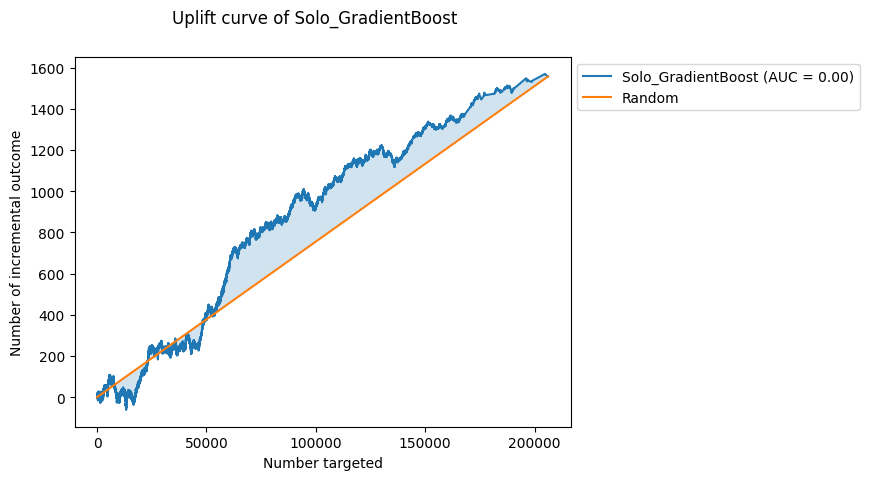

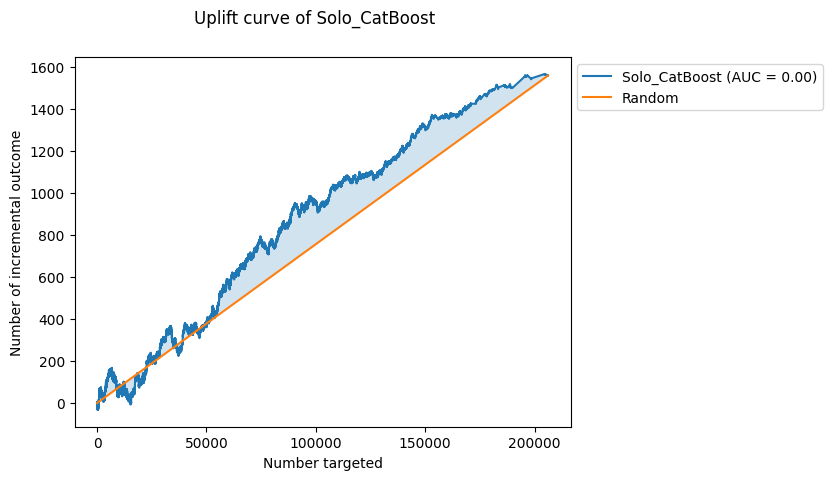

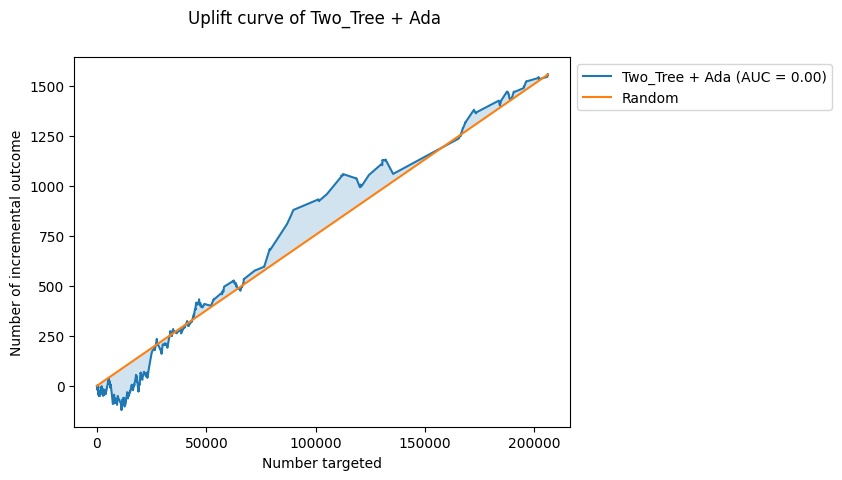

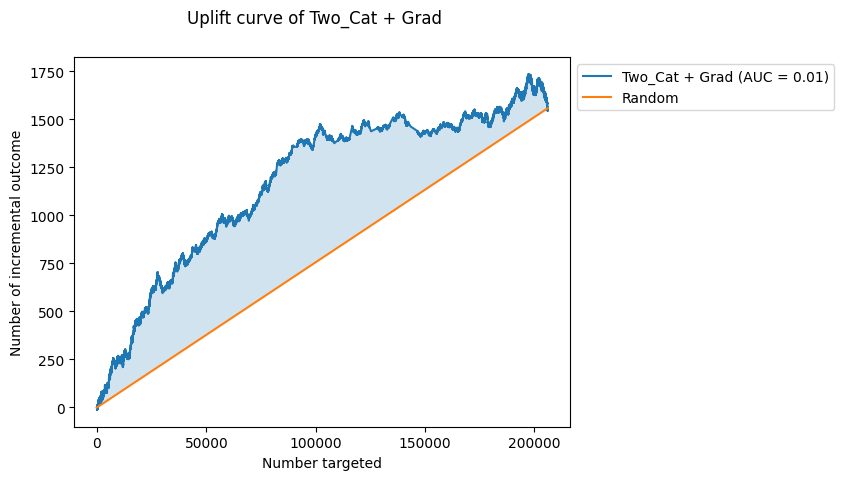

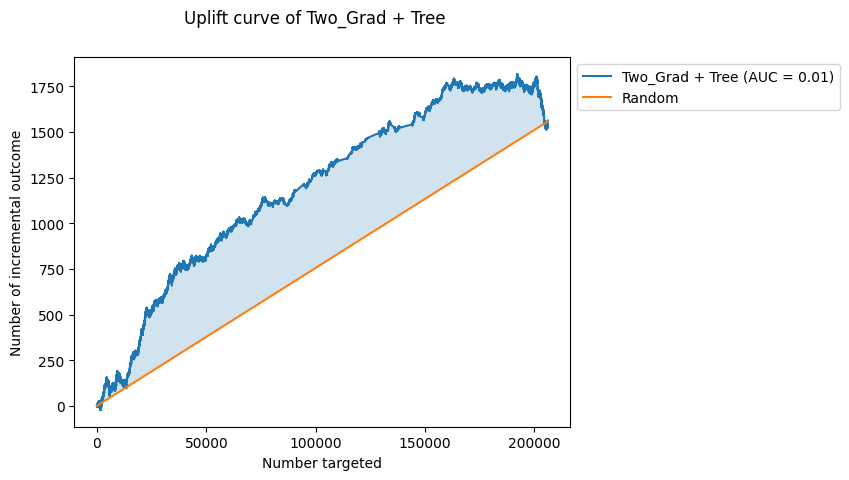

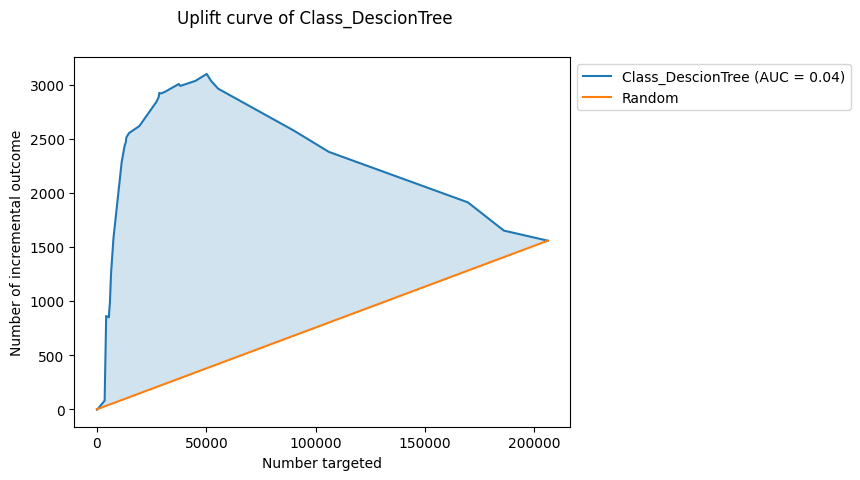

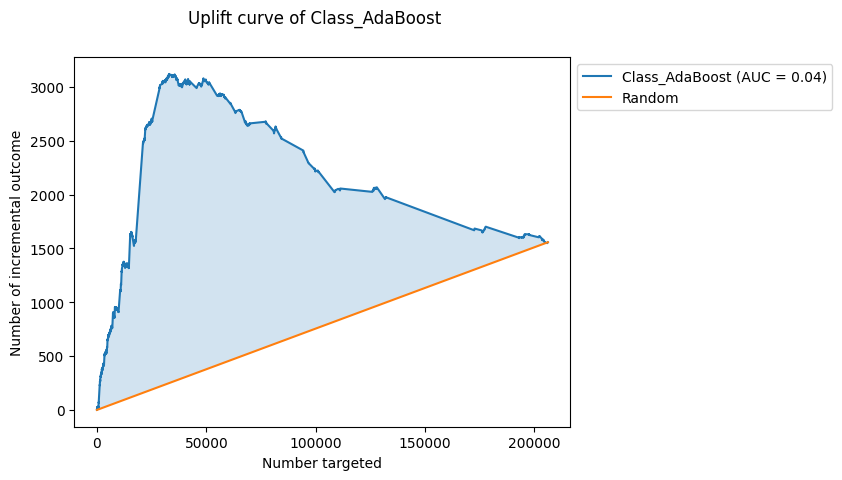

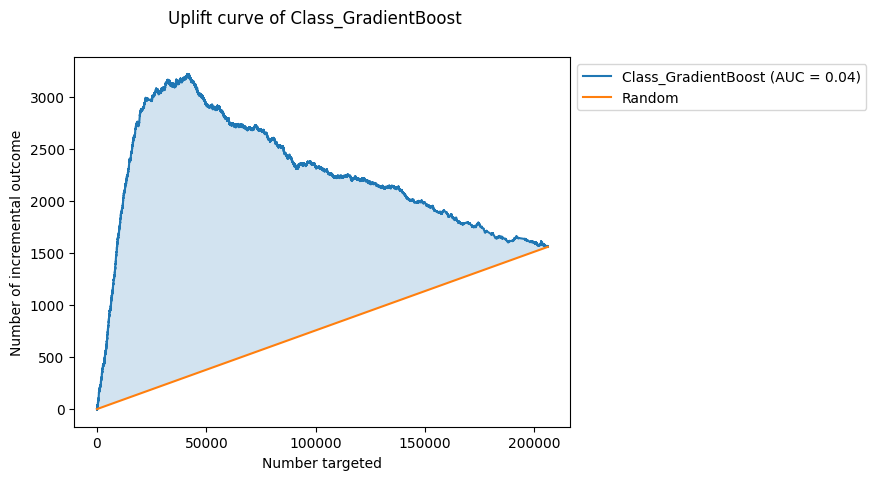

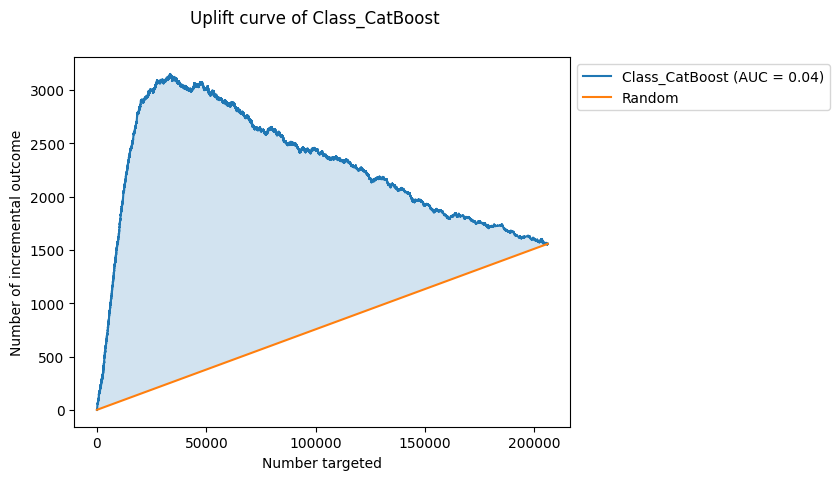

In [ ]:
PackedModels = pack_models(UpliftModels)
display_uplift(PackedModels)